# Action Observation Region Masking

Author: Olaf Borghi olafborghi@gmail.com

Based on 
- https://lukas-snoek.com/NI-edu/fMRI-introduction/week_7/nilearn.html#region-extraction
- https://github.com/lrsktr/tewa-neuroimaging/blob/main/08_masking-and-extracting-signals/08_masking-extracting-signals.ipynb

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [1]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype.interfaces import fsl
from nilearn import plotting, datasets, image
from nilearn.image import math_img
from nilearn.maskers import MultiNiftiMasker
from pathlib import Path
from pprint import pprint
from glob import glob
print(nl.__version__)

0.9.2


**Set fixed parameters**

In [2]:
# fixed folders
basedir = Path("/home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"
masks_templates_dir = outputdir / "masks_templates"
second_level_dir = outputdir / "second_level"
AON_second_level_dir = second_level_dir / "AON-task"
action_second_level_dir = second_level_dir / "action-task"

# make folder to store the brain atlases
if not os.path.exists(outputdir / "brain_atlases"):
    os.makedirs(outputdir / "brain_atlases")
atlas_dir = outputdir / "brain_atlases"


# make folder to store the ROI masks
if not os.path.exists(masks_templates_dir / "ROI_masks"):
    os.makedirs(masks_templates_dir / "ROI_masks")
roi_dir = masks_templates_dir / "ROI_masks"

In [3]:
# load the MNI template
template = datasets.load_mni152_template(resolution=1)

# store the MNI template also locally
mni_image_path = f"{masks_templates_dir}/mni_template_1mm.nii.gz"
template.to_filename(mni_image_path)

## load the brain atlas 

# juelich brain atlas
ju_atlas = datasets.fetch_atlas_juelich("maxprob-thr0-1mm", data_dir=atlas_dir, symmetric_split=True)
print(f"The Juelich atlas includes {len(ju_atlas.labels) - 1} regions")
print(f"Shape of the  Juelich atlas: {ju_atlas.maps.shape}")
print(f"The Juelich atlas image is located at: {ju_atlas.filename}")

The Juelich atlas includes 124 regions
Shape of the  Juelich atlas: (182, 218, 182)
The Juelich atlas image is located at: /home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/derivatives/brain_atlases/fsl/data/atlases/Juelich/Juelich-maxprob-thr0-1mm.nii.gz


In [4]:
# print the regions of the juelich brain atlas
print("Juelich Brain Atlas Regions:")
pprint(ju_atlas.labels)

Juelich Brain Atlas Regions:
['Background',
 'Left GM Anterior intra-parietal sulcus hIP1 L',
 'Right GM Anterior intra-parietal sulcus hIP1 R',
 'Left GM Anterior intra-parietal sulcus hIP2 L',
 'Right GM Anterior intra-parietal sulcus hIP2 R',
 'Left GM Anterior intra-parietal sulcus hIP3 L',
 'Right GM Anterior intra-parietal sulcus hIP3 R',
 'Left GM Amygdala_centromedial group L',
 'Right GM Amygdala_centromedial group R',
 'Left GM Amygdala_laterobasal group L',
 'Right GM Amygdala_laterobasal group R',
 'Left GM Amygdala_superficial group L',
 'Right GM Amygdala_superficial group R',
 "Left GM Broca's area BA44 L",
 "Right GM Broca's area BA44 R",
 "Left GM Broca's area BA45 L",
 "Right GM Broca's area BA45 R",
 'Left GM Hippocampus cornu ammonis L',
 'Right GM Hippocampus cornu ammonis R',
 'Left GM Hippocampus entorhinal cortex L',
 'Right GM Hippocampus entorhinal cortex R',
 'Left GM Hippocampus dentate gyrus L',
 'Right GM Hippocampus dentate gyrus R',
 'Left GM Hippocampus

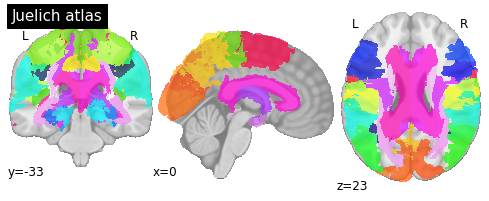

In [5]:
# plot the juelich brain atlas
plotting.plot_roi(ju_atlas.maps, title="Juelich atlas", draw_cross=False, bg_img=template, black_bg=False)

Let's try out some manipulations to get familiar with handling atlases!

In [6]:
ju_maxprob_atlas_img = image.load_img(ju_atlas['maps'])
print("ju_maxprob_atlas_img is a 3D image with shape %s" % (ju_maxprob_atlas_img.shape,))

ju_maxprob_atlas_img is a 3D image with shape (182, 218, 182)


In [7]:
region_int_labels = np.unique(ju_maxprob_atlas_img.get_fdata())
n_regions = region_int_labels.size

print("There are %i different regions in the Jülich Brain atlas!" % n_regions)

There are 125 different regions in the Jülich Brain atlas!


In [8]:
region_int_labels

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124.])

In [9]:
idx = 2
region_with_value2 = ju_atlas['labels'][idx]
print("The region with value 2 in the Jülich Brain atlas is: %s" % region_with_value2)

The region with value 2 in the Jülich Brain atlas is: Right GM Anterior intra-parietal sulcus hIP1 R


### Select the Regions of Interest

I am interested in the typical Action Observation Network, a network of brain areas that usually includes the
- Inferior parietal lobule --> Juelich Brain Atlas
- Inferior frontal Gyrus = pars opercularis (BA 44) = pars triangularis (BA 45) = Broca Area --> Juelich Brain Atlas
- Premotor cortex (PM) --> Juelich Brain Atlas
- Primary motor cortex (M1) --> Juelich Brain Atlas (also includes SMA)
- Primary somatosensory cortex (S1) --> Juelich Brain Atlas
- Secondary somatosensory cortex (S2) --> Juelich Brain Atlas

To get the anatomical regions, I will use deterministic versions of the Harvard-Oxford and the Juelich Brain atlasses. 

First, I created a function to extract multiple sub-brain-regions from each atlas, in order to then create a binary mask of the whole region.


In [10]:
def MyNonProbMasker(atlas, regions):
    
    '''A quick function to extract multiple brain regions from a 
    non probabilistic 3D atlas in Nilearn. 
    
    Inputs: 
    Atlas = A brain atlas with keys for the 3D nifty image and the region labels
    Regions = A list of strings with the region names as defined by atlas.labels
    
    Returns: 
    mask_imgs = A dictionary, region : mask_img '''
            
    mask_imgs = {}
    
    for idx, roi in enumerate(regions):
        
        roi_idx  = atlas.labels.index(roi)
        
        print(roi_idx, " = ", atlas['labels'][roi_idx], " = ", roi)
        
        mask_img = image.new_img_like(atlas.maps, image.get_data(atlas.maps)==roi_idx)
        mask_imgs[roi]=mask_img
        plotting.plot_roi(mask_img, title=roi, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")
        
    return mask_imgs

### Inferior parietal lobule (IPL)

For this region I use the non-probabilistic version of the Juelich brain atlas.

I start by creating to lists with the label names of the whole region that I am interested in.

In [11]:
left_ipl = ['Left GM Inferior parietal lobule PF L',
            'Left GM Inferior parietal lobule PFcm L',
            'Left GM Inferior parietal lobule PFm L',
            'Left GM Inferior parietal lobule PFop L',
            'Left GM Inferior parietal lobule PFt L',
            'Left GM Inferior parietal lobule Pga L',
            'Left GM Inferior parietal lobule PGp L']
            
right_ipl = ['Right GM Inferior parietal lobule PF R',
             'Right GM Inferior parietal lobule PFcm R',
             'Right GM Inferior parietal lobule PFm R',
             'Right GM Inferior parietal lobule PFop R',
             'Right GM Inferior parietal lobule PFt R',
             'Right GM Inferior parietal lobule Pga R',
             'Right GM Inferior parietal lobule PGp R']

I then compute an individual mask for each subpart of the left IPL in the Jülich brain atlas. 
To do so, I use the function that I created above. 

**Left IPL**

27  =  Left GM Inferior parietal lobule PF L  =  Left GM Inferior parietal lobule PF L
29  =  Left GM Inferior parietal lobule PFcm L  =  Left GM Inferior parietal lobule PFcm L
31  =  Left GM Inferior parietal lobule PFm L  =  Left GM Inferior parietal lobule PFm L
33  =  Left GM Inferior parietal lobule PFop L  =  Left GM Inferior parietal lobule PFop L
35  =  Left GM Inferior parietal lobule PFt L  =  Left GM Inferior parietal lobule PFt L
37  =  Left GM Inferior parietal lobule Pga L  =  Left GM Inferior parietal lobule Pga L
39  =  Left GM Inferior parietal lobule PGp L  =  Left GM Inferior parietal lobule PGp L


{'Left GM Inferior parietal lobule PF L': <nibabel.nifti1.Nifti1Image at 0x7f82b460f9d0>,
 'Left GM Inferior parietal lobule PFcm L': <nibabel.nifti1.Nifti1Image at 0x7f82b4687370>,
 'Left GM Inferior parietal lobule PFm L': <nibabel.nifti1.Nifti1Image at 0x7f82780fcaf0>,
 'Left GM Inferior parietal lobule PFop L': <nibabel.nifti1.Nifti1Image at 0x7f8270926fd0>,
 'Left GM Inferior parietal lobule PFt L': <nibabel.nifti1.Nifti1Image at 0x7f826e1aafa0>,
 'Left GM Inferior parietal lobule Pga L': <nibabel.nifti1.Nifti1Image at 0x7f82708db550>,
 'Left GM Inferior parietal lobule PGp L': <nibabel.nifti1.Nifti1Image at 0x7f82708e7490>}

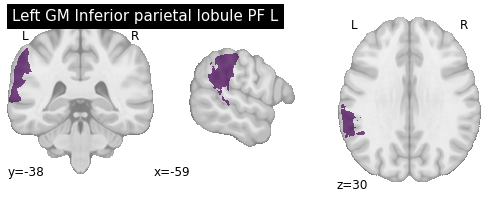

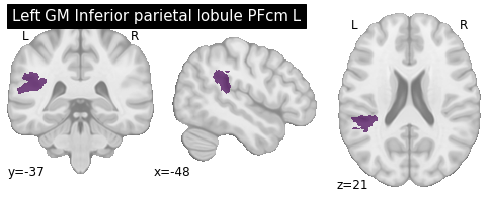

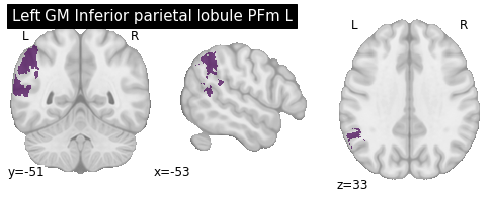

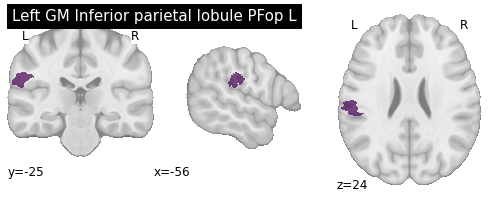

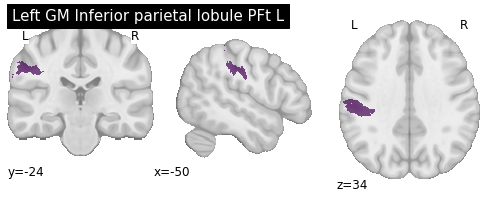

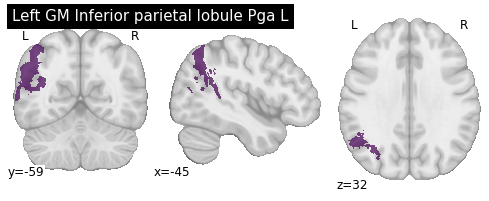

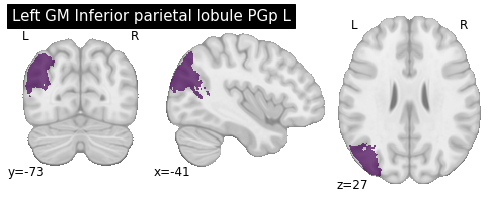

In [12]:
left_ipl_imgs = MyNonProbMasker(ju_atlas, left_ipl)
left_ipl_imgs

However, like this I end up with seven individual masks, but actually, I want a single mask for all of the left IPL. As the regions should not overlap and are all binary, I can use nilearn.math.img to sum them up. 

In [13]:
left_ipl_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7", 
                               img1=left_ipl_imgs.get(left_ipl[0]), 
                               img2=left_ipl_imgs.get(left_ipl[1]),
                               img3=left_ipl_imgs.get(left_ipl[2]), 
                               img4=left_ipl_imgs.get(left_ipl[3]),
                               img5=left_ipl_imgs.get(left_ipl[4]), 
                               img6=left_ipl_imgs.get(left_ipl[5]),
                               img7=left_ipl_imgs.get(left_ipl[6]))

Quick check whether we still have a binary image

In [14]:
lipl_int_labels = np.unique(left_ipl_mask.get_fdata())
n_regions = lipl_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lipl_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


And finally plot our mask of the left IPL!

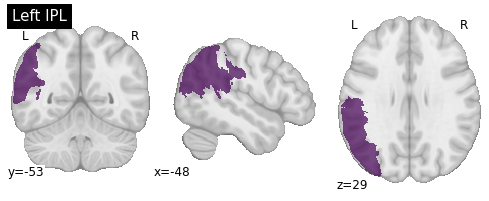

In [15]:
plotting.plot_roi(left_ipl_mask, title="Left IPL", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Alright! That worked really well :) 

**Now let's do the same with the right IPL!**

28  =  Right GM Inferior parietal lobule PF R  =  Right GM Inferior parietal lobule PF R
30  =  Right GM Inferior parietal lobule PFcm R  =  Right GM Inferior parietal lobule PFcm R
32  =  Right GM Inferior parietal lobule PFm R  =  Right GM Inferior parietal lobule PFm R
34  =  Right GM Inferior parietal lobule PFop R  =  Right GM Inferior parietal lobule PFop R
36  =  Right GM Inferior parietal lobule PFt R  =  Right GM Inferior parietal lobule PFt R
38  =  Right GM Inferior parietal lobule Pga R  =  Right GM Inferior parietal lobule Pga R
40  =  Right GM Inferior parietal lobule PGp R  =  Right GM Inferior parietal lobule PGp R


{'Right GM Inferior parietal lobule PF R': <nibabel.nifti1.Nifti1Image at 0x7f826b9ff6d0>,
 'Right GM Inferior parietal lobule PFcm R': <nibabel.nifti1.Nifti1Image at 0x7f827a8f4310>,
 'Right GM Inferior parietal lobule PFm R': <nibabel.nifti1.Nifti1Image at 0x7f82758e8ca0>,
 'Right GM Inferior parietal lobule PFop R': <nibabel.nifti1.Nifti1Image at 0x7f826e227af0>,
 'Right GM Inferior parietal lobule PFt R': <nibabel.nifti1.Nifti1Image at 0x7f827312dc40>,
 'Right GM Inferior parietal lobule Pga R': <nibabel.nifti1.Nifti1Image at 0x7f8273185700>,
 'Right GM Inferior parietal lobule PGp R': <nibabel.nifti1.Nifti1Image at 0x7f826e206f70>}

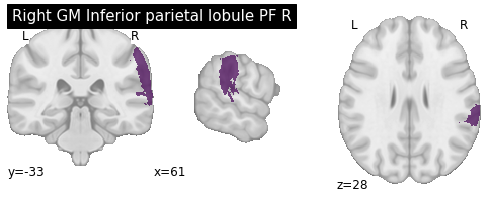

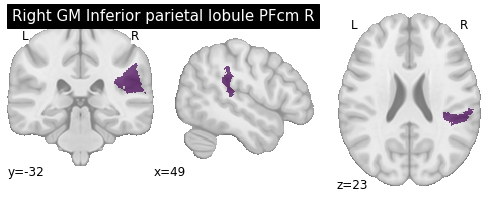

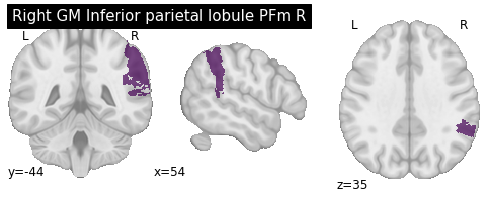

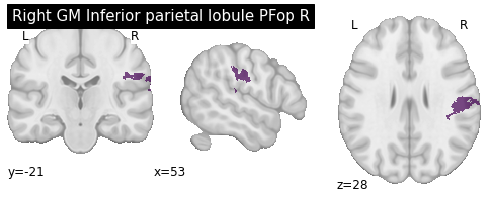

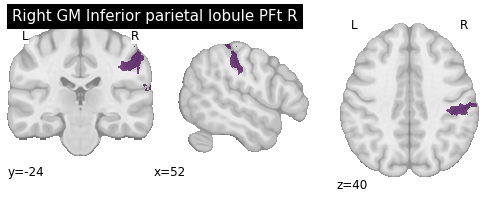

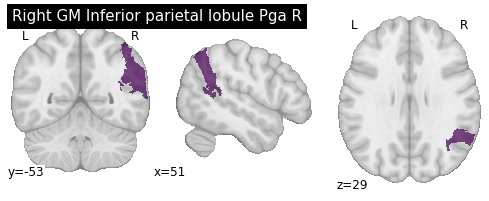

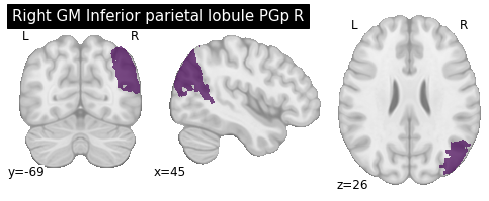

In [16]:
right_ipl_imgs = MyNonProbMasker(ju_atlas, right_ipl)
right_ipl_imgs

In [17]:
# sum up the binary masks of the subregions to get one larger mask
right_ipl_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7", 
                                img1=right_ipl_imgs.get(right_ipl[0]), 
                                img2=right_ipl_imgs.get(right_ipl[1]),
                                img3=right_ipl_imgs.get(right_ipl[2]), 
                                img4=right_ipl_imgs.get(right_ipl[3]),
                                img5=right_ipl_imgs.get(right_ipl[4]), 
                                img6=right_ipl_imgs.get(right_ipl[5]),
                                img7=right_ipl_imgs.get(right_ipl[6]))

In [18]:
# quick sanity check
ripl_int_labels = np.unique(right_ipl_mask.get_fdata())
n_regions = ripl_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {ripl_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


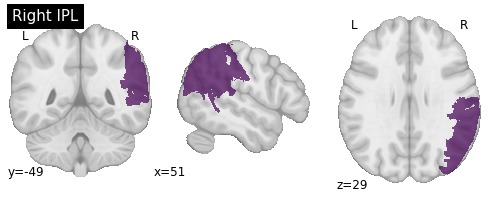

In [19]:
# plot the region
plotting.plot_roi(right_ipl_mask, title="Right IPL", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Let's save the mask locally, so that I can re-use them at later times. 

In [20]:
# save the left ipl mask to path 
left_ipl_mask_path = f"{roi_dir}/left_inferior_parietal_lobule_mask.nii.gz"
left_ipl_mask.to_filename(left_ipl_mask_path)

# save the right ipl mask to path 
right_ipl_mask_path = f"{roi_dir}/right_inferior_parietal_lobule_mask.nii.gz"
right_ipl_mask.to_filename(right_ipl_mask_path)

### Inferior frontal gyrus (IFG)

For this area I will use the non-probabilistic version of the Juelich brain atlas.
The area consists of BA44 (pars opercularis) and BA45 (pars triangularis), also known as Broca Areas. 

In [21]:
# store the labels of the regions in a list (separate for each hemisphere)
left_ifg = ["Left GM Broca's area BA44 L",
            "Left GM Broca's area BA45 L"]

right_ifg = ["Right GM Broca's area BA44 R",
             "Right GM Broca's area BA45 R"]

**Left IFG**

13  =  Left GM Broca's area BA44 L  =  Left GM Broca's area BA44 L
15  =  Left GM Broca's area BA45 L  =  Left GM Broca's area BA45 L


{"Left GM Broca's area BA44 L": <nibabel.nifti1.Nifti1Image at 0x7f826b979400>,
 "Left GM Broca's area BA45 L": <nibabel.nifti1.Nifti1Image at 0x7f827811cf40>}

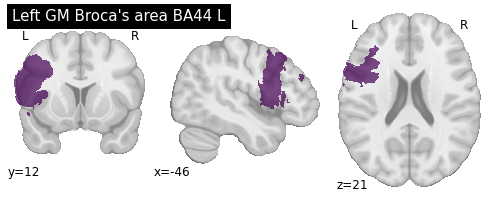

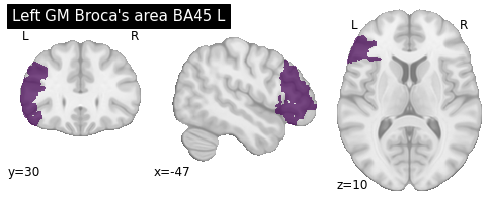

In [22]:
# use the function to compute the individual masks of each sub-region
left_ifg_imgs = MyNonProbMasker(ju_atlas, left_ifg)
left_ifg_imgs

In [23]:
# sum up the sub regions of the IFG for a mask of the whole right IFG
left_ifg_mask = image.math_img("img1 + img2", 
                                img1=left_ifg_imgs.get(left_ifg[0]), 
                                img2=left_ifg_imgs.get(left_ifg[1]))

In [24]:
# quick sanity check
lifg_int_labels = np.unique(left_ifg_mask.get_fdata())
n_regions = lifg_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lifg_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


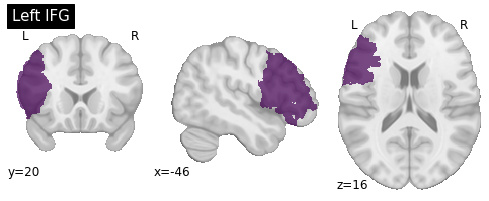

In [25]:
# plot the region
plotting.plot_roi(left_ifg_mask, title="Left IFG", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right IFG**

14  =  Right GM Broca's area BA44 R  =  Right GM Broca's area BA44 R
16  =  Right GM Broca's area BA45 R  =  Right GM Broca's area BA45 R


{"Right GM Broca's area BA44 R": <nibabel.nifti1.Nifti1Image at 0x7f826693d970>,
 "Right GM Broca's area BA45 R": <nibabel.nifti1.Nifti1Image at 0x7f82709d8fa0>}

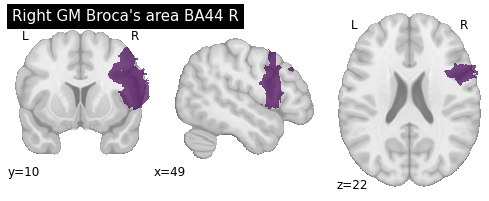

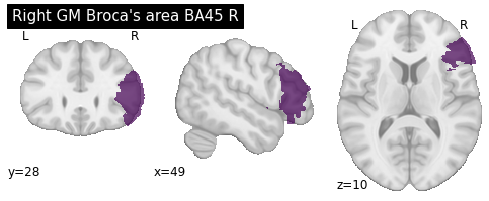

In [26]:
# use the function to compute the individual masks of each sub-region
right_ifg_imgs = MyNonProbMasker(ju_atlas, right_ifg)
right_ifg_imgs

In [27]:
# sum up the sub regions of the IFG for a mask of the whole right IFG
right_ifg_mask = image.math_img("img1 + img2", 
                                img1=right_ifg_imgs.get(right_ifg[0]), 
                                img2=right_ifg_imgs.get(right_ifg[1]))

In [28]:
# quick sanity check
rifg_int_labels = np.unique(right_ifg_mask.get_fdata())
n_regions = rifg_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {rifg_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


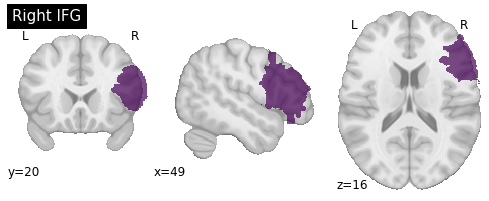

In [29]:
# plot the region
plotting.plot_roi(right_ifg_mask, title="Right IFG", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both IFG masks locally

In [30]:
# save the left ifg mask to path 
left_ifg_mask_path = f"{roi_dir}/left_inferior_frontal_gyrus_mask.nii.gz"
left_ifg_mask.to_filename(left_ifg_mask_path)

# save the right ifg mask to path 
right_ifg_mask_path = f"{roi_dir}/right_inferior_frontal_gyrus_mask.nii.gz"
right_ifg_mask.to_filename(right_ifg_mask_path)

### Premotor cortex (PM)

For this area I will use the non-probabilistic version of the Juelich brain atlas.

In [31]:
# store the labels of the regions in a list (separate for each hemisphere)
left_pm = ['Left GM Premotor cortex BA6 L']
right_pm = [ 'Right GM Premotor cortex BA6 R']

**Left PM**

91  =  Left GM Premotor cortex BA6 L  =  Left GM Premotor cortex BA6 L


{'Left GM Premotor cortex BA6 L': <nibabel.nifti1.Nifti1Image at 0x7f8270955d90>}

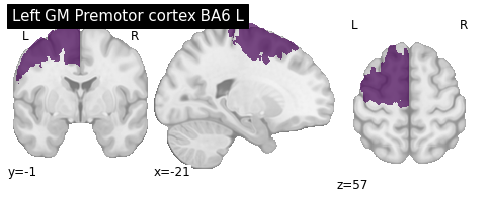

In [32]:
# use the function to binarize the individual masks of the region
left_pm_img = MyNonProbMasker(ju_atlas, left_pm)
left_pm_img

**Right PM**

92  =  Right GM Premotor cortex BA6 R  =  Right GM Premotor cortex BA6 R


{'Right GM Premotor cortex BA6 R': <nibabel.nifti1.Nifti1Image at 0x7f82691a2130>}

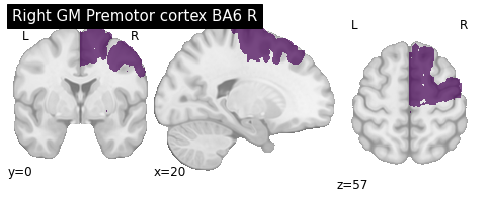

In [33]:
# use the function to compute the individual masks of each sub-region
right_pm_img = MyNonProbMasker(ju_atlas, right_pm)
right_pm_img

Save both PM masks locally

In [34]:
# save the left pm mask to path 
left_pm_mask = left_pm_img.get(left_pm[0])
left_pm_mask_path = f"{roi_dir}/left_premotor_cortex_mask.nii.gz"
left_pm_mask.to_filename(left_pm_mask_path)

# save the right pm mask to path 
right_pm_mask = right_pm_img.get(right_pm[0])
right_pm_mask_path = f"{roi_dir}/right_premotor_cortex_mask.nii.gz"
right_pm_mask.to_filename(right_pm_mask_path)

### Primary Motor Area (M1)

For this area I will use the non-probabilistic version of the Juelich brain atlas.

In [35]:
# store the labels of the regions in a list (separate for each hemisphere)

left_m1 = ['Left GM Primary motor cortex BA4a L',
           'Left GM Primary motor cortex BA4p L',]

right_m1 = ['Right GM Primary motor cortex BA4a R',
            'Right GM Primary motor cortex BA4p R',]

**Left M1**

47  =  Left GM Primary motor cortex BA4a L  =  Left GM Primary motor cortex BA4a L
49  =  Left GM Primary motor cortex BA4p L  =  Left GM Primary motor cortex BA4p L


{'Left GM Primary motor cortex BA4a L': <nibabel.nifti1.Nifti1Image at 0x7f826b9aca90>,
 'Left GM Primary motor cortex BA4p L': <nibabel.nifti1.Nifti1Image at 0x7f8269191fa0>}

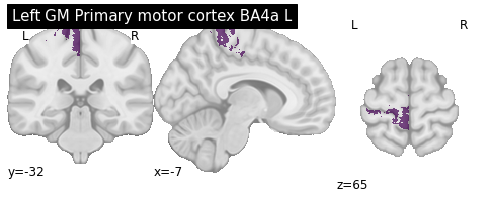

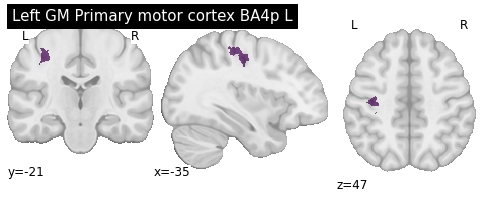

In [36]:
# use the function to compute the individual masks of each sub-region
left_m1_imgs = MyNonProbMasker(ju_atlas, left_m1)
left_m1_imgs

In [37]:
# sum up the sub regions of the lM1 
left_m1_mask = image.math_img("img1 + img2", 
                              img1=left_m1_imgs.get(left_m1[0]), 
                              img2=left_m1_imgs.get(left_m1[1]))

In [38]:
# quick sanity check
lm1_int_labels = np.unique(left_m1_mask.get_fdata())
n_regions = lm1_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lm1_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


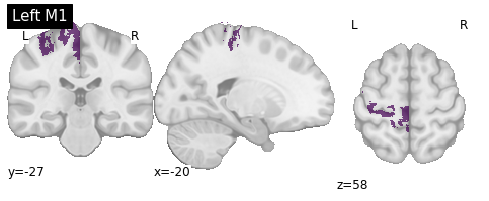

In [39]:
# plot the region
plotting.plot_roi(left_m1_mask, title="Left M1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right M1**

48  =  Right GM Primary motor cortex BA4a R  =  Right GM Primary motor cortex BA4a R
50  =  Right GM Primary motor cortex BA4p R  =  Right GM Primary motor cortex BA4p R


{'Right GM Primary motor cortex BA4a R': <nibabel.nifti1.Nifti1Image at 0x7f82691607f0>,
 'Right GM Primary motor cortex BA4p R': <nibabel.nifti1.Nifti1Image at 0x7f826e227190>}

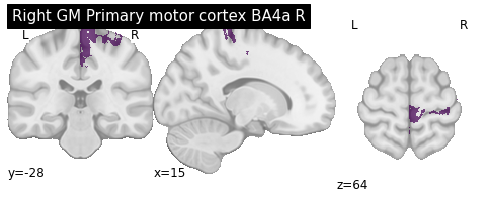

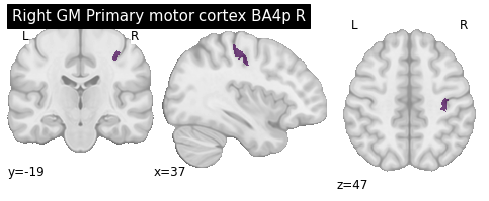

In [40]:
# use the function to compute the individual masks of each sub-region
right_m1_imgs = MyNonProbMasker(ju_atlas, right_m1)
right_m1_imgs

In [41]:
# sum up the sub regions of the rM1 
right_m1_mask = image.math_img("img1 + img2", 
                                img1=right_m1_imgs.get(right_m1[0]), 
                                img2=right_m1_imgs.get(right_m1[1]))

In [42]:
# quick sanity check
rm1_int_labels = np.unique(right_m1_mask.get_fdata())
n_regions = rm1_int_labels.size

print(f"There are {n_regions} different regions in the  mask! Check here if the mask is binary (should be 0 and 1): {rm1_int_labels}")

There are 2 different regions in the  mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


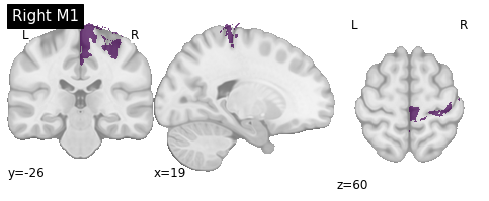

In [43]:
# plot the region
plotting.plot_roi(right_m1_mask, title="Right M1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both M1 masks locally

In [44]:
# save the left m1 mask to path 
left_m1_mask_path = f"{roi_dir}/left_primary_motor_cortex_mask.nii.gz"
left_m1_mask.to_filename(left_m1_mask_path)

# save the right m1 mask to path 
right_m1_mask_path = f"{roi_dir}/right_primary_motor_cortex_mask.nii.gz"
right_m1_mask.to_filename(right_m1_mask_path)

### Primary somatosensory cortex

For this area I will use the non-probabilistic version of the Julich brain atlas.

In [45]:
# store the labels of the regions in a list (separate for each hemisphere)

left_s1 = ['Left GM Primary somatosensory cortex BA1 L',
           'Left GM Primary somatosensory cortex BA2 L',
           'Left GM Primary somatosensory cortex BA3a L',
           'Left GM Primary somatosensory cortex BA3b L']

right_s1 = ['Right GM Primary somatosensory cortex BA1 R',
            'Right GM Primary somatosensory cortex BA2 R',
            'Right GM Primary somatosensory cortex BA3a R',
            'Right GM Primary somatosensory cortex BA3b R']

**Left S1**

51  =  Left GM Primary somatosensory cortex BA1 L  =  Left GM Primary somatosensory cortex BA1 L
53  =  Left GM Primary somatosensory cortex BA2 L  =  Left GM Primary somatosensory cortex BA2 L
55  =  Left GM Primary somatosensory cortex BA3a L  =  Left GM Primary somatosensory cortex BA3a L
57  =  Left GM Primary somatosensory cortex BA3b L  =  Left GM Primary somatosensory cortex BA3b L


{'Left GM Primary somatosensory cortex BA1 L': <nibabel.nifti1.Nifti1Image at 0x7f826909d5b0>,
 'Left GM Primary somatosensory cortex BA2 L': <nibabel.nifti1.Nifti1Image at 0x7f82731d0f40>,
 'Left GM Primary somatosensory cortex BA3a L': <nibabel.nifti1.Nifti1Image at 0x7f8269201c10>,
 'Left GM Primary somatosensory cortex BA3b L': <nibabel.nifti1.Nifti1Image at 0x7f826e0f3c40>}

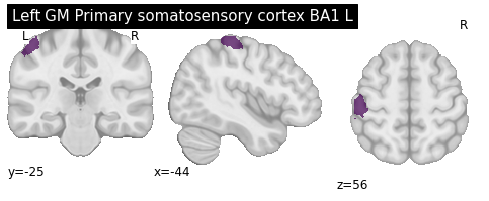

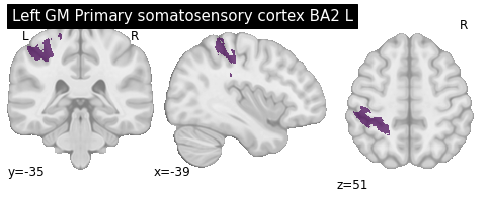

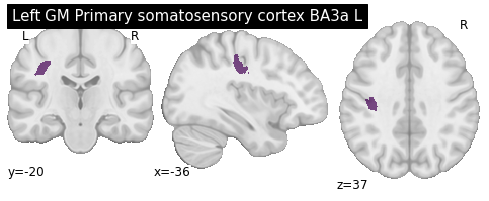

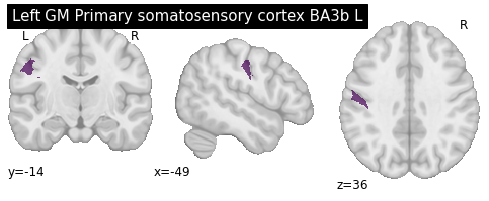

In [46]:
# use the function to compute the individual masks of each sub-region
left_s1_imgs = MyNonProbMasker(ju_atlas, left_s1)
left_s1_imgs

In [47]:
# sum up the sub regions 
left_s1_mask = image.math_img("img1 + img2 + img3 + img4", 
                              img1=left_s1_imgs.get(left_s1[0]), 
                              img2=left_s1_imgs.get(left_s1[1]),
                              img3=left_s1_imgs.get(left_s1[2]),
                              img4=left_s1_imgs.get(left_s1[3]))

In [48]:
# quick sanity check
ls1_int_labels = np.unique(left_s1_mask.get_fdata())
n_regions = ls1_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {ls1_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


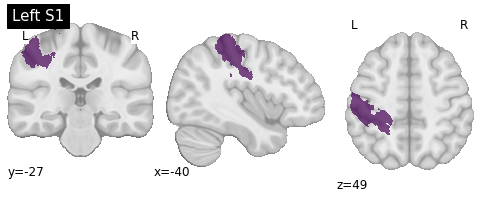

In [49]:
# plot the region
plotting.plot_roi(left_s1_mask, title="Left S1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right S1**

52  =  Right GM Primary somatosensory cortex BA1 R  =  Right GM Primary somatosensory cortex BA1 R
54  =  Right GM Primary somatosensory cortex BA2 R  =  Right GM Primary somatosensory cortex BA2 R
56  =  Right GM Primary somatosensory cortex BA3a R  =  Right GM Primary somatosensory cortex BA3a R
58  =  Right GM Primary somatosensory cortex BA3b R  =  Right GM Primary somatosensory cortex BA3b R


{'Right GM Primary somatosensory cortex BA1 R': <nibabel.nifti1.Nifti1Image at 0x7f82640bf490>,
 'Right GM Primary somatosensory cortex BA2 R': <nibabel.nifti1.Nifti1Image at 0x7f82619a8e20>,
 'Right GM Primary somatosensory cortex BA3a R': <nibabel.nifti1.Nifti1Image at 0x7f826e225f40>,
 'Right GM Primary somatosensory cortex BA3b R': <nibabel.nifti1.Nifti1Image at 0x7f8264163f40>}

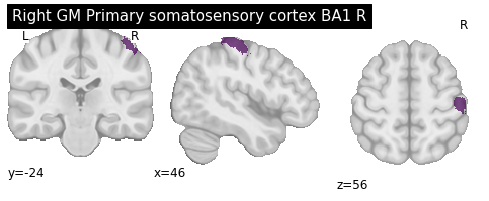

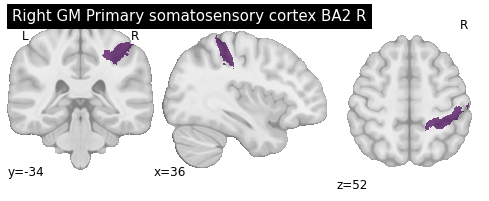

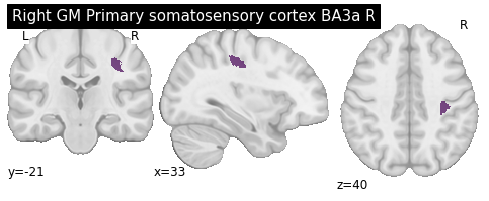

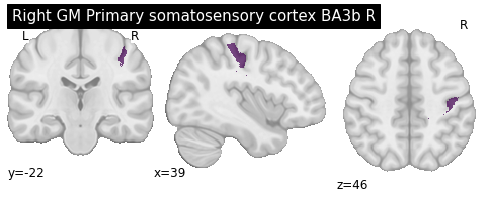

In [50]:
# use the function to compute the individual masks of each sub-region
right_s1_imgs = MyNonProbMasker(ju_atlas, right_s1)
right_s1_imgs

In [51]:
# sum up the sub regions 
right_s1_mask = image.math_img("img1 + img2 + img3 + img4", 
                              img1=right_s1_imgs.get(right_s1[0]), 
                              img2=right_s1_imgs.get(right_s1[1]),
                              img3=right_s1_imgs.get(right_s1[2]),
                              img4=right_s1_imgs.get(right_s1[3]))

In [52]:
# quick sanity check
rs1_int_labels = np.unique(right_s1_mask.get_fdata())
n_regions = rs1_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {rs1_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


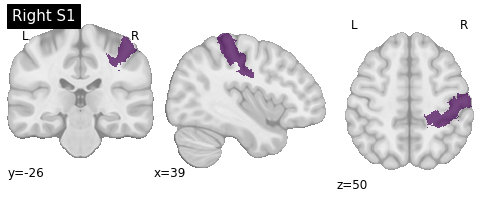

In [53]:
# plot the region
plotting.plot_roi(right_s1_mask, title="Right S1", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both S1 masks locally

In [54]:
# save the left s1 mask to path 
left_s1_mask_path = f"{roi_dir}/left_primary_somatosensory_cortex_mask.nii.gz"
left_s1_mask.to_filename(left_s1_mask_path)

# save the right s1 mask to path 
right_s1_mask_path = f"{roi_dir}/right_primary_somatosensory_cortex_mask.nii.gz"
right_s1_mask.to_filename(right_s1_mask_path)

### Secondary somatosensory cortex

For this area I will use the non-probabilistic version of the Julich brain atlas.

In [55]:
# store the labels of the regions in a list (separate for each hemisphere)

left_s2 = ['Left GM Secondary somatosensory cortex / Parietal operculum OP1 L',
           'Left GM Secondary somatosensory cortex / Parietal operculum OP2 L',
           'Left GM Secondary somatosensory cortex / Parietal operculum OP3 L',
           'Left GM Secondary somatosensory cortex / Parietal operculum OP4 L']

right_s2 = ['Right GM Secondary somatosensory cortex / Parietal operculum OP1 R',
            'Right GM Secondary somatosensory cortex / Parietal operculum OP2 R',
            'Right GM Secondary somatosensory cortex / Parietal operculum OP3 R',
            'Right GM Secondary somatosensory cortex / Parietal operculum OP4 R']

**Left S1**

59  =  Left GM Secondary somatosensory cortex / Parietal operculum OP1 L  =  Left GM Secondary somatosensory cortex / Parietal operculum OP1 L
61  =  Left GM Secondary somatosensory cortex / Parietal operculum OP2 L  =  Left GM Secondary somatosensory cortex / Parietal operculum OP2 L
63  =  Left GM Secondary somatosensory cortex / Parietal operculum OP3 L  =  Left GM Secondary somatosensory cortex / Parietal operculum OP3 L
65  =  Left GM Secondary somatosensory cortex / Parietal operculum OP4 L  =  Left GM Secondary somatosensory cortex / Parietal operculum OP4 L


{'Left GM Secondary somatosensory cortex / Parietal operculum OP1 L': <nibabel.nifti1.Nifti1Image at 0x7f82640bf370>,
 'Left GM Secondary somatosensory cortex / Parietal operculum OP2 L': <nibabel.nifti1.Nifti1Image at 0x7f82640f6f40>,
 'Left GM Secondary somatosensory cortex / Parietal operculum OP3 L': <nibabel.nifti1.Nifti1Image at 0x7f826e155c40>,
 'Left GM Secondary somatosensory cortex / Parietal operculum OP4 L': <nibabel.nifti1.Nifti1Image at 0x7f825f601bb0>}

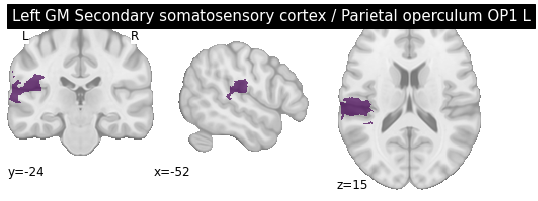

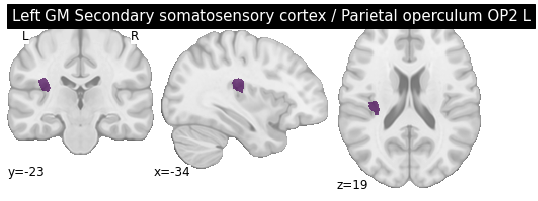

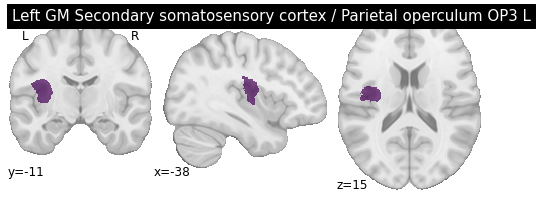

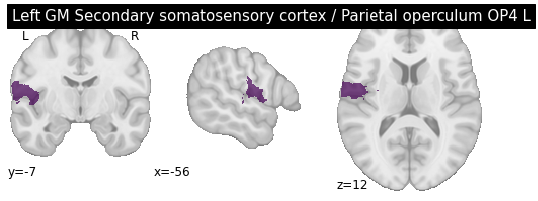

In [56]:
# use the function to compute the individual masks of each sub-region
left_s2_imgs = MyNonProbMasker(ju_atlas, left_s2)
left_s2_imgs

In [57]:
# sum up the sub regions 
left_s2_mask = image.math_img("img1 + img2 + img3 + img4", 
                              img1=left_s2_imgs.get(left_s2[0]), 
                              img2=left_s2_imgs.get(left_s2[1]),
                              img3=left_s2_imgs.get(left_s2[2]),
                              img4=left_s2_imgs.get(left_s2[3]))

In [58]:
# quick sanity check
ls2_int_labels = np.unique(left_s2_mask.get_fdata())
n_regions = ls2_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {ls2_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


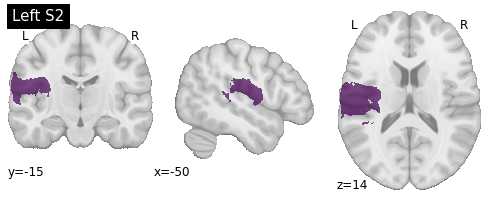

In [59]:
# plot the region
plotting.plot_roi(left_s2_mask, title="Left S2", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

**Right S2**

60  =  Right GM Secondary somatosensory cortex / Parietal operculum OP1 R  =  Right GM Secondary somatosensory cortex / Parietal operculum OP1 R
62  =  Right GM Secondary somatosensory cortex / Parietal operculum OP2 R  =  Right GM Secondary somatosensory cortex / Parietal operculum OP2 R
64  =  Right GM Secondary somatosensory cortex / Parietal operculum OP3 R  =  Right GM Secondary somatosensory cortex / Parietal operculum OP3 R
66  =  Right GM Secondary somatosensory cortex / Parietal operculum OP4 R  =  Right GM Secondary somatosensory cortex / Parietal operculum OP4 R


{'Right GM Secondary somatosensory cortex / Parietal operculum OP1 R': <nibabel.nifti1.Nifti1Image at 0x7f82640f6ca0>,
 'Right GM Secondary somatosensory cortex / Parietal operculum OP2 R': <nibabel.nifti1.Nifti1Image at 0x7f825f4ae1c0>,
 'Right GM Secondary somatosensory cortex / Parietal operculum OP3 R': <nibabel.nifti1.Nifti1Image at 0x7f825f5febb0>,
 'Right GM Secondary somatosensory cortex / Parietal operculum OP4 R': <nibabel.nifti1.Nifti1Image at 0x7f8264138820>}

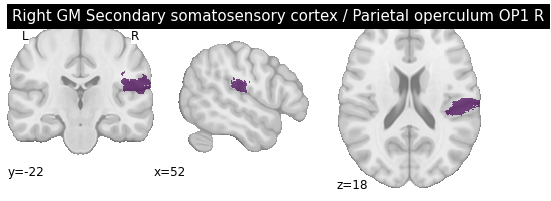

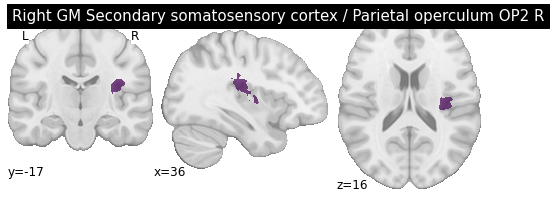

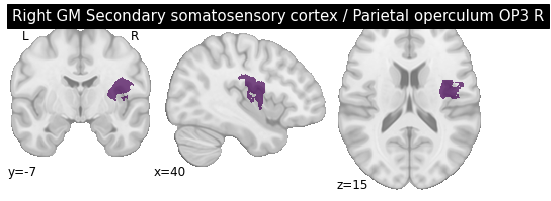

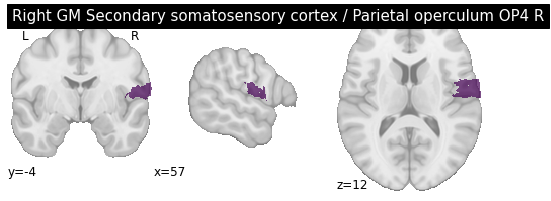

In [60]:
# use the function to compute the individual masks of each sub-region
right_s2_imgs = MyNonProbMasker(ju_atlas, right_s2)
right_s2_imgs

In [61]:
# sum up the sub regions 
right_s2_mask = image.math_img("img1 + img2 + img3 + img4", 
                              img1=right_s2_imgs.get(right_s2[0]), 
                              img2=right_s2_imgs.get(right_s2[1]),
                              img3=right_s2_imgs.get(right_s2[2]),
                              img4=right_s2_imgs.get(right_s2[3]))

In [62]:
# quick sanity check
rs2_int_labels = np.unique(right_s2_mask.get_fdata())
n_regions = rs2_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {rs2_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


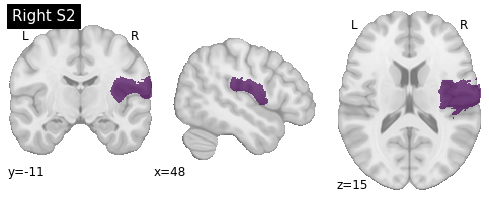

In [63]:
# plot the region
plotting.plot_roi(right_s2_mask, title="Right S2", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Save both S2 masks locally

In [64]:
# save the left s2 mask to path 
left_s2_mask_path = f"{roi_dir}/left_secondary_somatosensory_cortex_mask.nii.gz"
left_s2_mask.to_filename(left_s2_mask_path)

# save the right s2 mask to path 
right_s2_mask_path = f"{roi_dir}/right_secondary_somatosensory_cortex_mask.nii.gz"
right_s2_mask.to_filename(right_s2_mask_path)

## Sanity Checks

We have our total of 12 masks now, let's check, if they are all ok!

- Inferior parietal lobule --> left_ipl_mask & right_ipl_mask
- Inferior frontal gyrus (IFG) -->  left_ifg_mask & right_ifg_mask
- Premotor cortex (PM) --> left_pm_mask & right_pm_mask
- Primary motor cortex (M1) --> left_m1_mask & right_m1_mask
- Primary somatosensory cortex (S1) --> left_s1_mask & right_s1_mask
- Secondary somatosensory cortex (S2) --> left_s2_mask & right_s2_mask

In [65]:
# lets store all masks in a list
all_masks = [left_ipl_mask, right_ipl_mask,
             left_ifg_mask, right_ifg_mask,
             left_pm_mask, right_pm_mask,
             left_m1_mask, right_m1_mask,
             left_s1_mask, right_s1_mask,
             left_s2_mask, right_s2_mask]

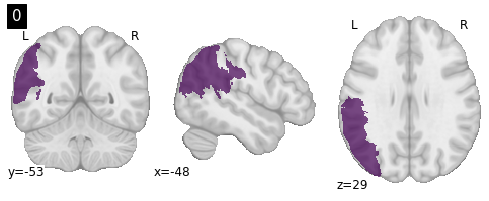

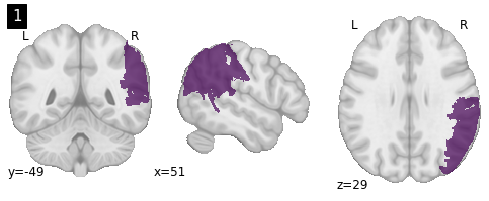

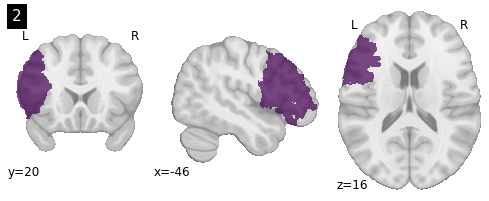

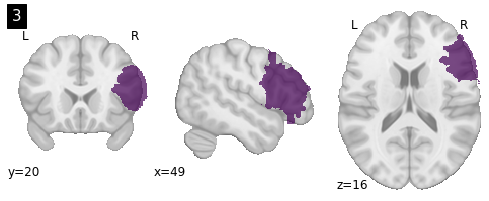

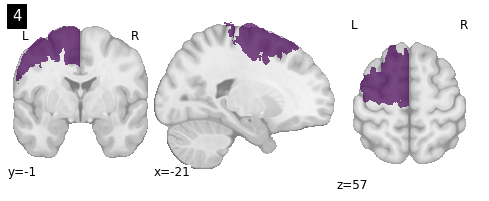

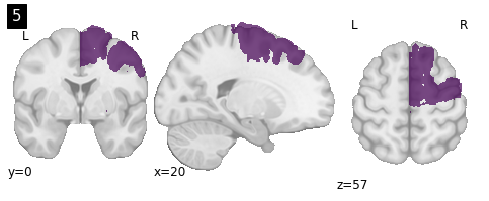

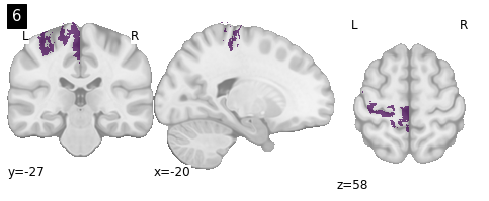

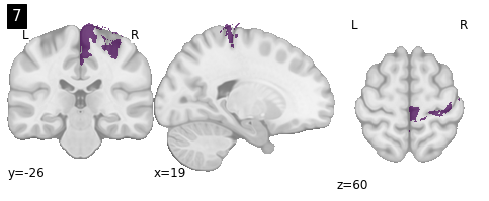

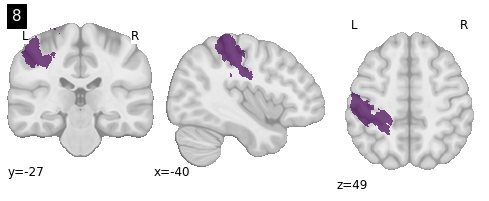

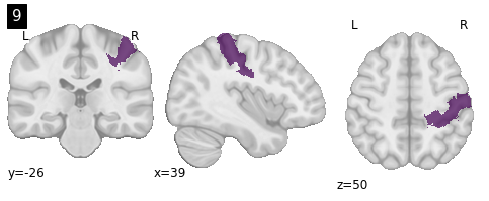

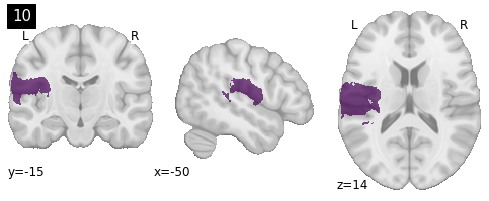

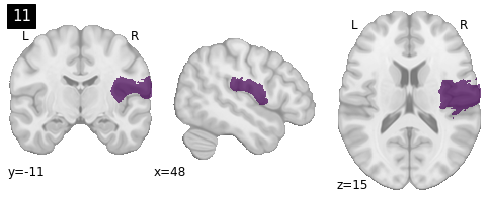

In [66]:
# plot them all
for idx, mask in enumerate(all_masks):
    plotting.plot_roi(mask, title=idx, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

In [67]:
# lets sum up all of our anatomical ROIs to check if they overlap
anat_roi_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7 + img8 + img9 +img10 + img11 + img12", 
                               img1 = left_ipl_mask,
                               img2 = right_ipl_mask,
                               img3 = left_ifg_mask,
                               img4 = right_ifg_mask,
                               img5 = left_pm_mask,
                               img6 = right_pm_mask,
                               img7 = left_m1_mask,
                               img8 = right_m1_mask,
                               img9 = left_s1_mask,
                               img10 = right_s1_mask,
                               img11 = left_s2_mask,
                               img12 = right_s2_mask)

In [68]:
# quick sanity check
anat_roi_mask_int_labels = np.unique(anat_roi_mask.get_fdata())
n_regions = anat_roi_mask_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {anat_roi_mask_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


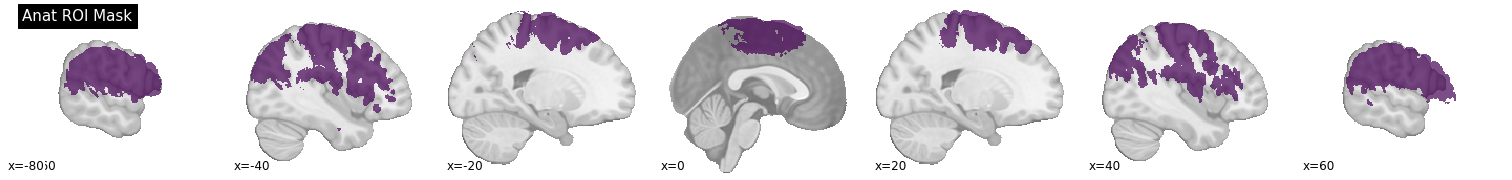

In [69]:
# plot the region
plotting.plot_roi(anat_roi_mask, title="Anat ROI Mask", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis", display_mode = 'x', cut_coords=np.arange(-80,80,20))

-------------

### Overlap checks - Run this part of the script only if you already ran the feature processing masking script

**Overlap**: 
- IPL overlaps with LOC
- IPL overlaps with pSTS

**Calculate Overlap**

In [70]:
def MyOverlapCalculator(mask1, mask2):
    # load mask data
    mask1_data = mask1.get_fdata()
    mask2_data = mask2.get_fdata()
    
    # plot both masks
    plot = plotting.plot_roi(mask1, draw_cross=False, display_mode = 'x', cut_coords=np.arange(-80,80,20), bg_img=template, black_bg=False, cmap="viridis", alpha=0.7)
    plot.add_contours(mask2, filled=False, alpha=1, colors="k")
    
    # calculate the number of overlapping voxels
    overlap = np.sum((mask1_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels:", overlap)

**Load the relevant masks created in the fp script**

In [71]:
left_loc_path = f"{roi_dir}/left_lateral_occipital_cortex_mask_no_overlap.nii.gz"
left_loc_mask = nib.load(left_loc_path)
right_loc_path = f"{roi_dir}/right_lateral_occipital_cortex_mask_no_overlap.nii.gz"
right_loc_mask = nib.load(right_loc_path)
left_pSTS_path = f"{roi_dir}/left_pSTS_mask.nii.gz"
left_pSTS_mask = nib.load(left_pSTS_path)
right_pSTS_path = f"{roi_dir}/right_pSTS_mask.nii.gz"
right_pSTS_mask = nib.load(right_pSTS_path)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Number of overlapping voxels: 955
Number of overlapping voxels: 1571
Number of overlapping voxels: 2478
Number of overlapping voxels: 3152


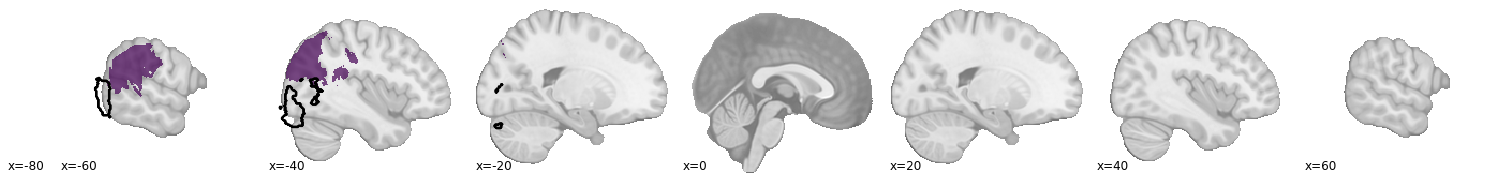

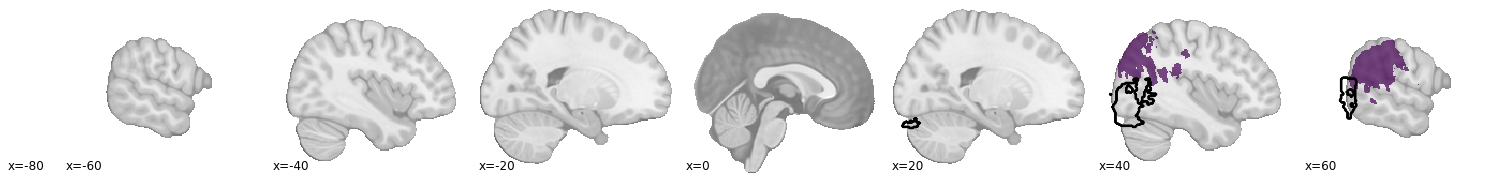

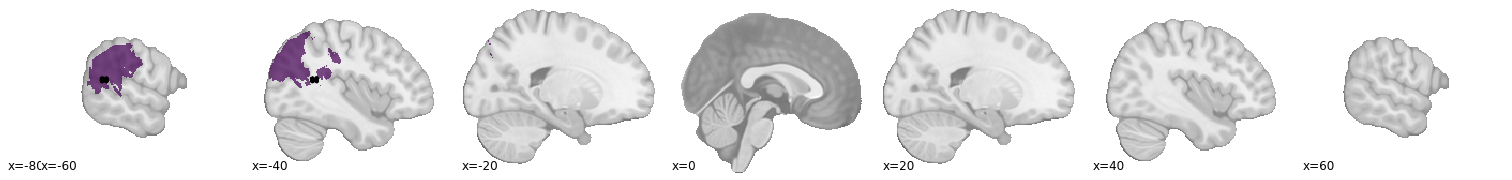

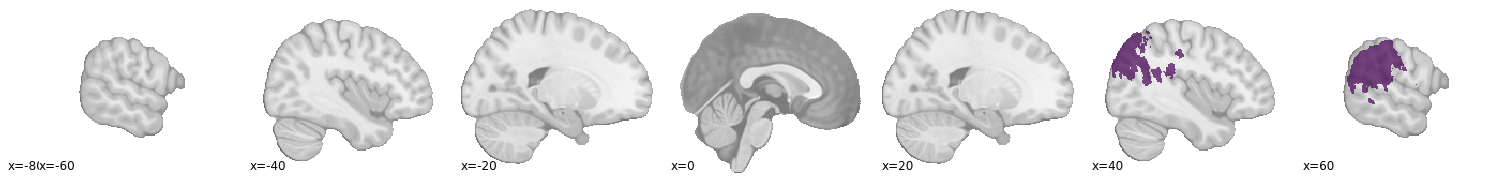

In [72]:
MyOverlapCalculator(left_ipl_mask, left_loc_mask)
MyOverlapCalculator(right_ipl_mask, right_loc_mask)
MyOverlapCalculator(left_ipl_mask, left_pSTS_mask)
MyOverlapCalculator(right_ipl_mask, right_pSTS_mask)

In [73]:
from copy import copy

def MyOverlapRemover(mask1, mask2):
    ''' Takes two brain masks as input, calculates the overlapping voxels between the two masks, 
    and removes the voxels that overlap between mask1 and mask2 from mask1, returning it as 
    a new mask1 without the overlap '''
    # load mask data
    mask1_data = mask1.get_fdata()
    mask2_data = mask2.get_fdata()

    # calculate the number of overlapping voxels
    overlap1 = np.sum((mask1_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels in original mask:", overlap1)

    # get indices of overlapping voxel between masks
    idx = (mask1_data > 0) & (mask2_data > 0)

    # fill the overlap with 0 in mask 1
    newmask_data = mask1_data.copy()
    newmask_data[idx] = 0

    # create a new Nifti1Image with the newmask_data and the affine from mask1
    newmask = nib.Nifti1Image(newmask_data, affine=mask1.affine)

    # calculate the number of overlapping voxels with new mask 1
    overlap2 = np.sum((newmask_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels with new mask:", overlap2)

    # plot both masks
    plot = plotting.plot_roi(newmask, draw_cross=False, display_mode='x', cut_coords=np.arange(-80, 80, 20), bg_img=template, black_bg=False, cmap="viridis", alpha=0.7)
    plot.add_contours(mask2, filled=False, alpha=1, colors="k")

    return newmask

Number of overlapping voxels in original mask: 955
Number of overlapping voxels with new mask: 0
Number of overlapping voxels in original mask: 1571
Number of overlapping voxels with new mask: 0


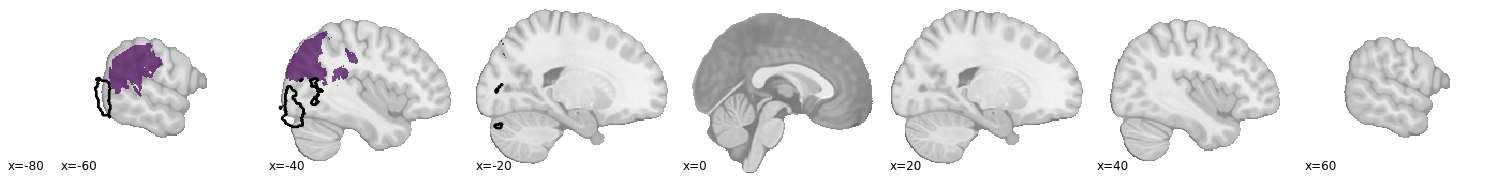

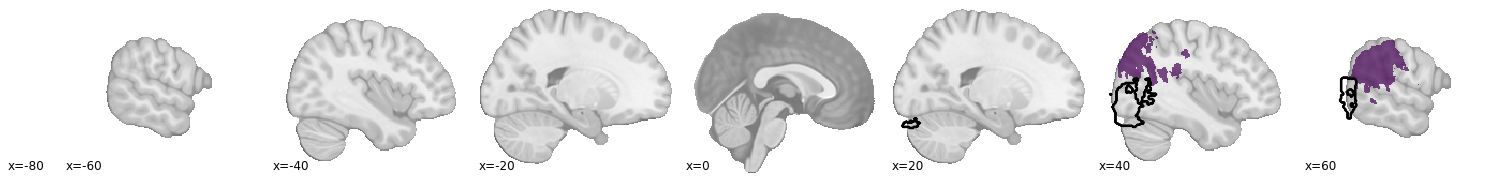

In [74]:
# new IPL masks without the overlap with LOC

# left ipl with left loc
left_ipl_nooverlap_loc = MyOverlapRemover(left_ipl_mask, left_loc_mask)
# right ipl with right loc
right_ipl_nooverlap_loc = MyOverlapRemover(right_ipl_mask, right_loc_mask)

Number of overlapping voxels in original mask: 2478
Number of overlapping voxels with new mask: 0
Number of overlapping voxels in original mask: 3152
Number of overlapping voxels with new mask: 0


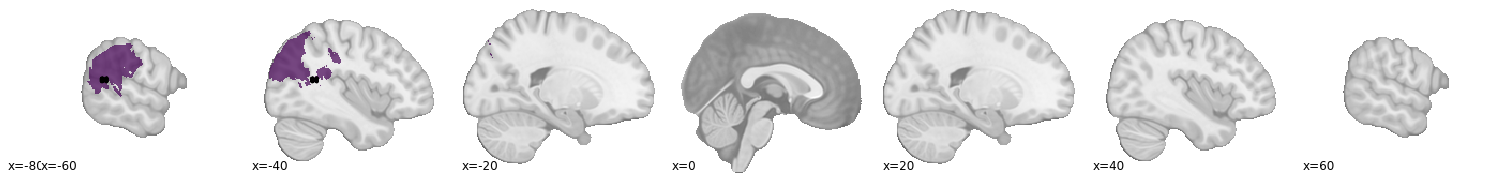

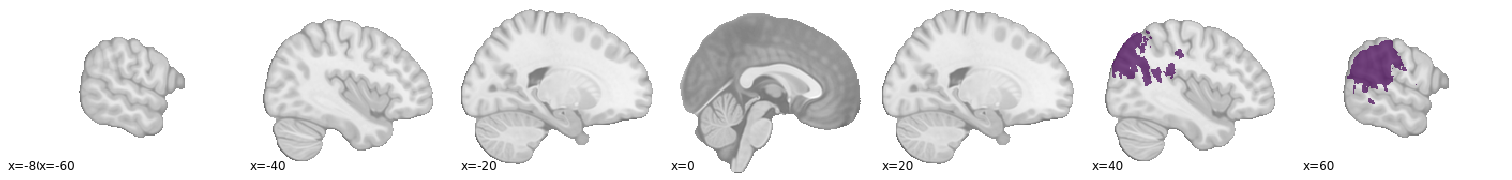

In [75]:
# new IPL masks without the overlap with pSTS

# left ipl with left pSTS
left_ipl_nooverlap = MyOverlapRemover(left_ipl_nooverlap_loc, left_pSTS_mask)
# right ipl with right loc
right_ipl_nooverlap = MyOverlapRemover(right_ipl_nooverlap_loc, right_pSTS_mask)

In [76]:
# save the left ifg mask to path 
left_ipl_nooverlap_path = f"{roi_dir}/left_inferior_parietal_lobule_mask_no_overlap.nii.gz"
left_ipl_nooverlap.to_filename(left_ipl_nooverlap_path)

# save the right ifg mask to path 
right_ipl_nooverlap_path = f"{roi_dir}/right_inferior_parietal_lobule_mask_no_overlap.nii.gz"
right_ipl_nooverlap.to_filename(right_ipl_nooverlap_path)

----------------------

## Sanity Checks

We have our total of 12 masks now, let's check, if they are all ok!

- Inferior parietal lobule --> left_ipl_mask & right_ipl_mask
- Inferior frontal gyrus (IFG) -->  left_ifg_mask & right_ifg_mask
- Premotor cortex (PM) --> left_pm_mask & right_pm_mask
- Primary motor cortex (M1) --> left_m1_mask & right_m1_mask
- Primary somatosensory cortex (S1) --> left_s1_mask & right_s1_mask
- Secondary somatosensory cortex (S2) --> left_s2_mask & right_s2_mask

In [77]:
# lets store all masks in a list
all_masks = [left_ipl_mask, right_ipl_mask,
             left_ifg_mask, right_ifg_mask,
             left_pm_mask, right_pm_mask,
             left_m1_mask, right_m1_mask,
             left_s1_mask, right_s1_mask,
             left_s2_mask, right_s2_mask]

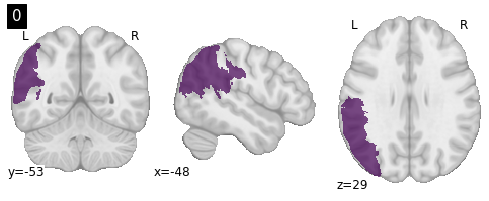

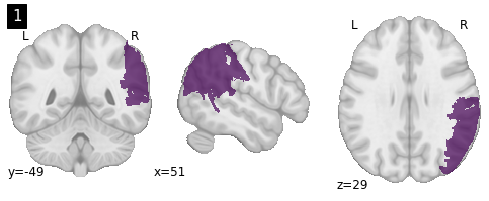

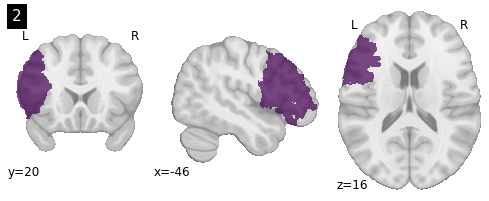

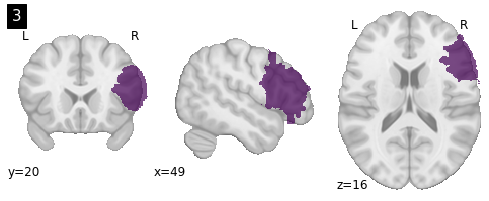

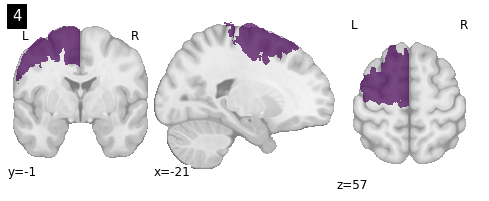

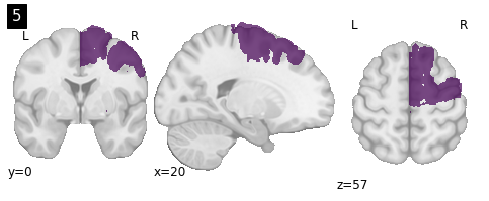

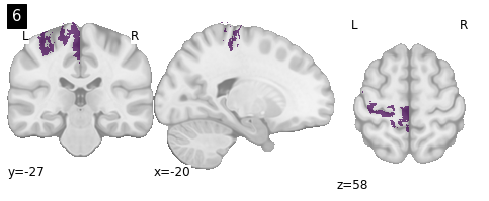

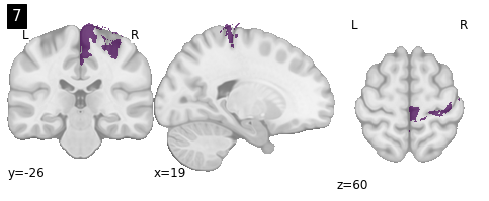

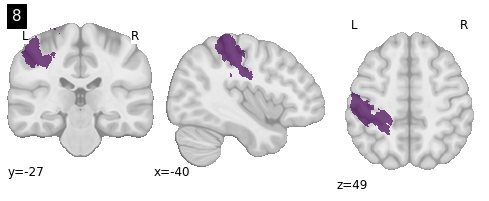

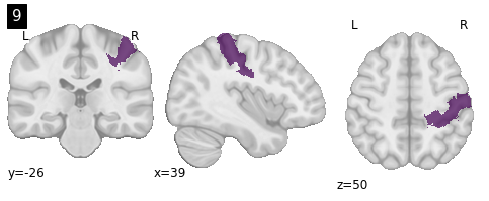

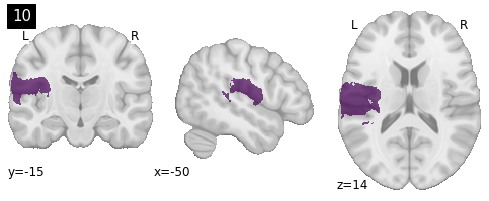

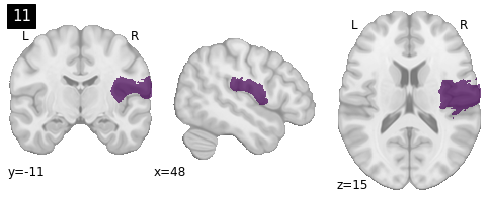

In [78]:
# plot them all
for idx, mask in enumerate(all_masks):
    plotting.plot_roi(mask, title=idx, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

In [79]:
# lets sum up all of our anatomical ROIs to check if they overlap
anat_roi_mask = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7 + img8 + img9 +img10 + img11 + img12", 
                               img1 = left_ipl_nooverlap,
                               img2 = right_ipl_nooverlap,
                               img3 = left_ifg_mask,
                               img4 = right_ifg_mask,
                               img5 = left_pm_mask,
                               img6 = right_pm_mask,
                               img7 = left_m1_mask,
                               img8 = right_m1_mask,
                               img9 = left_s1_mask,
                               img10 = right_s1_mask,
                               img11 = left_s2_mask,
                               img12 = right_s2_mask)

In [80]:
# quick sanity check
anat_roi_mask_int_labels = np.unique(anat_roi_mask.get_fdata())
n_regions = anat_roi_mask_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {anat_roi_mask_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


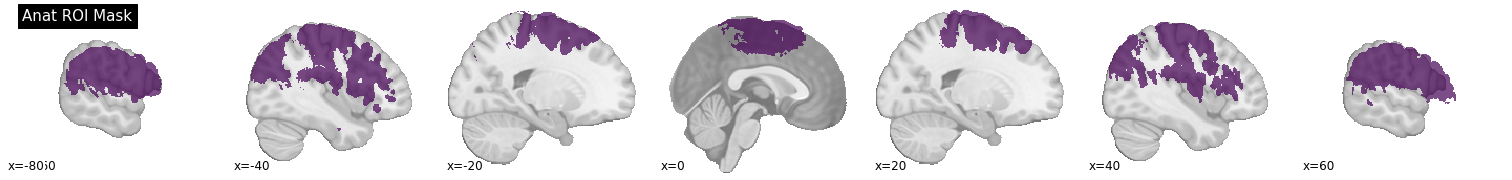

In [81]:
# plot the region
plotting.plot_roi(anat_roi_mask, title="Anat ROI Mask", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis", display_mode = 'x', cut_coords=np.arange(-80,80,20))

Looks great! Now we are ready to combine each mask with the AON_ACTION conjunction mask we created in the second level model, to get our final masks to extract the signal.

## Combine individual regions with conjunction mask to get final masks

In [82]:
conjunction_mask = f"{masks_templates_dir}/conjunction_mask.nii.gz"
conjunction_mask = nib.load(conjunction_mask)

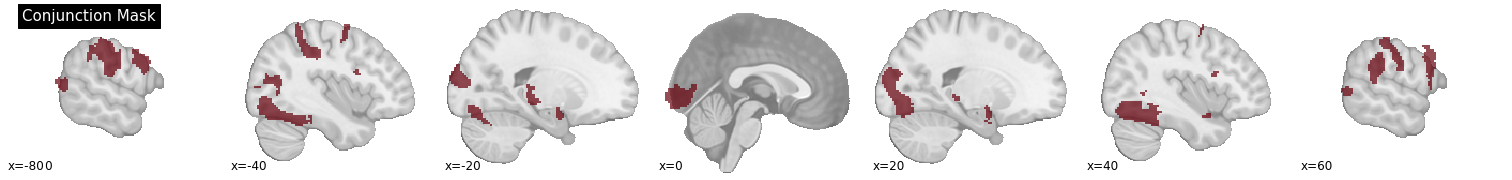

In [83]:
plotting.plot_roi(conjunction_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Conjunction Mask", bg_img = template, cmap="Reds_r", black_bg = False)

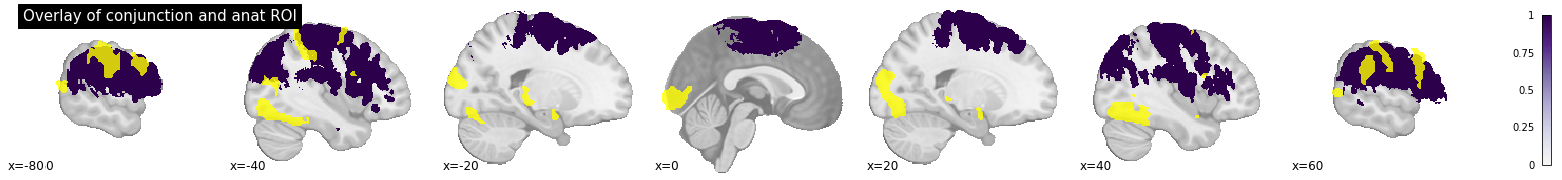

In [84]:
# Visually overlay the conjunction map with our a-priori ROI map
anat_roi_plot = plotting.plot_stat_map(anat_roi_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_plot.add_contours(conjunction_mask, filled=True, alpha=0.8, colors="yellow")

In [85]:
print("Shape of conjunction mask:", np.shape(conjunction_mask))
print("Affine of conjunction mask:")
print(conjunction_mask.affine)
print("Shape of anat_roi mask:", np.shape(anat_roi_mask))
print("Affine of anat_roi_mask:")
print(anat_roi_mask.affine)

Shape of conjunction mask: (91, 109, 91)
Affine of conjunction mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Shape of anat_roi mask: (182, 218, 182)
Affine of anat_roi_mask:
[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


So although are masks are aligned, they do not have the same shape and affine. Let's take care of this.

In [86]:
anat_roi_resamp = image.resample_img(
    anat_roi_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

print("New shape of anat_roi mask:", np.shape(anat_roi_resamp))
print("New affine of anat_roi mask:")
print(anat_roi_resamp.affine)

New shape of anat_roi mask: (91, 109, 91)
New affine of anat_roi mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


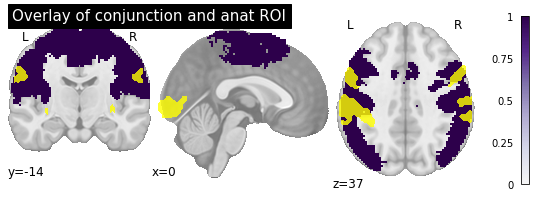

In [87]:
# Visually overlay the conjunction map with our resampled a-priori ROI map
anat_roi_resamp_plot = plotting.plot_stat_map(anat_roi_resamp, draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_resamp_plot.add_contours(conjunction_mask, filled=True, alpha=0.8, colors="yellow")

In [88]:
# save the anat roi mask to path 
anat_roi_mask_path = f"{roi_dir}/anat_roi_mask.nii.gz"
anat_roi_resamp.to_filename(anat_roi_mask_path)

#### Now combine each anatomical ROI with our conjunction mask in order to create to specific ROIs for data extraction from each region.

**Left Inferior Parietal Lobule * Conjunction**

In [89]:
# resample the left IPL mask
left_ipl_resamp = image.resample_img(
    left_ipl_nooverlap,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [90]:
left_ipl_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_ipl_resamp,
                                   img2 = conjunction_mask)

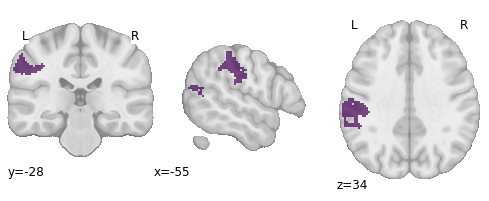

In [91]:
plotting.plot_roi(left_ipl_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [92]:
# save the mask to path 
left_ipl_aon_mask_path = f"{roi_dir}/left_ipl_aon_mask.nii.gz"
left_ipl_aon_mask.to_filename(left_ipl_aon_mask_path)

**Right IPL * Conjunction**

In [93]:
# resample the mask
right_ipl_resamp = image.resample_img(
    right_ipl_nooverlap,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [94]:
right_ipl_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_ipl_resamp,
                                   img2 = conjunction_mask)

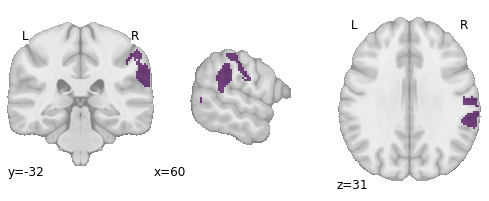

In [95]:
plotting.plot_roi(right_ipl_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [96]:
# save the mask to path 
right_ipl_aon_mask_path = f"{roi_dir}/right_ipl_aon_mask.nii.gz"
right_ipl_aon_mask.to_filename(right_ipl_aon_mask_path)

**Left IFG * Conjunction**

In [97]:
# resample the mask
left_ifg_resamp = image.resample_img(
    left_ifg_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [98]:
left_ifg_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_ifg_resamp,
                                   img2 = conjunction_mask)

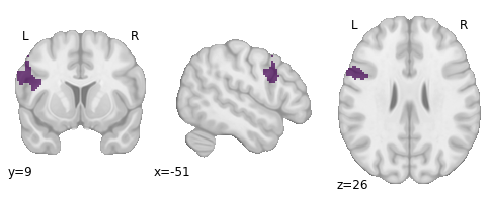

In [99]:
plotting.plot_roi(left_ifg_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [100]:
# save the mask to path 
left_ifg_aon_mask_path = f"{roi_dir}/left_ifg_aon_mask.nii.gz"
left_ifg_aon_mask.to_filename(left_ifg_aon_mask_path)

**Right IFG * Conjunction**

In [101]:
# resample the mask
right_ifg_resamp = image.resample_img(
    right_ifg_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [102]:
right_ifg_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_ifg_resamp,
                                   img2 = conjunction_mask)

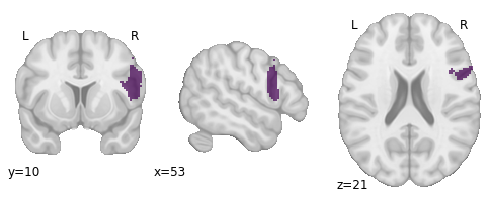

In [103]:
plotting.plot_roi(right_ifg_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [104]:
# save the mask to path 
right_ifg_aon_mask_path = f"{roi_dir}/right_ifg_aon_mask.nii.gz"
right_ifg_aon_mask.to_filename(right_ifg_aon_mask_path)

**Left premotor cortex * Conjunction**

In [105]:
# resample the mask
left_pm_resamp = image.resample_img(
    left_pm_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [106]:
left_pm_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_pm_resamp,
                                   img2 = conjunction_mask)

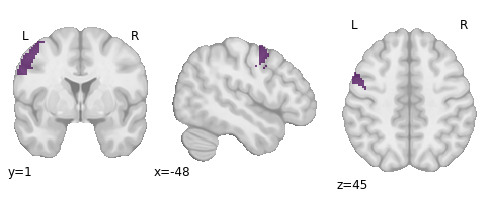

In [107]:
plotting.plot_roi(left_pm_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [108]:
# save the mask to path 
left_pm_aon_mask_path = f"{roi_dir}/left_pm_aon_mask.nii.gz"
left_pm_aon_mask.to_filename(left_pm_aon_mask_path)

**Right premotor cortex * Conjunction**

In [109]:
# resample the mask
right_pm_resamp = image.resample_img(
    right_pm_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [110]:
right_pm_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_pm_resamp,
                                   img2 = conjunction_mask)

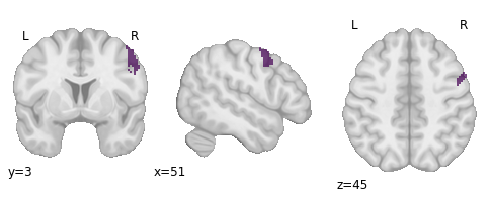

In [111]:
plotting.plot_roi(right_pm_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [112]:
# save the mask to path 
right_pm_aon_mask_path = f"{roi_dir}/right_pm_aon_mask.nii.gz"
right_pm_aon_mask.to_filename(right_pm_aon_mask_path)

**Left primary motor cortex (M1) * Conjunction**

In [113]:
# resample the mask
left_m1_resamp = image.resample_img(
    left_m1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [114]:
left_m1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_m1_resamp,
                                   img2 = conjunction_mask)

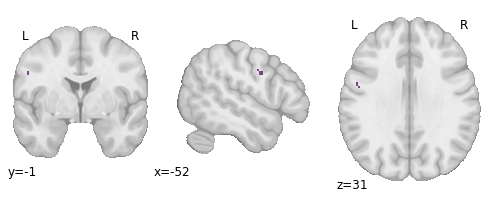

In [115]:
plotting.plot_roi(left_m1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [116]:
# save the mask to path 
left_m1_aon_mask_path = f"{roi_dir}/left_m1_aon_mask.nii.gz"
left_m1_aon_mask.to_filename(left_m1_aon_mask_path)

**Right M1 * Conjunction**

In [117]:
# resample the mask
right_m1_resamp = image.resample_img(
    right_m1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [118]:
right_m1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_m1_resamp,
                                   img2 = conjunction_mask)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


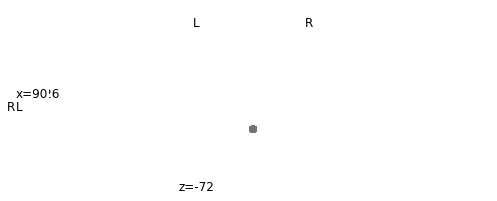

In [119]:
plotting.plot_roi(right_m1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

#### Empty mask -- No overlap in the right primary motor cortex - this could be based on the fact that in the action task participants only moved their right hand (--> more activation in the left motor cortex)

**Left primary somatosensory cortex (S1) * Conjunction**

In [120]:
# resample the mask
left_s1_resamp = image.resample_img(
    left_s1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [121]:
left_s1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_s1_resamp,
                                   img2 = conjunction_mask)

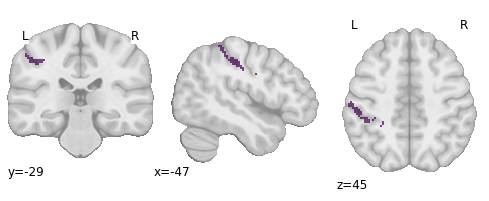

In [122]:
plotting.plot_roi(left_s1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [123]:
# save the mask to path 
left_s1_aon_mask_path = f"{roi_dir}/left_s1_aon_mask.nii.gz"
left_s1_aon_mask.to_filename(left_s1_aon_mask_path)

**Right primary somatosensory cortex (S1) * Conjunction**

In [124]:
# resample the mask
right_s1_resamp = image.resample_img(
    right_s1_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [125]:
right_s1_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_s1_resamp,
                                   img2 = conjunction_mask)

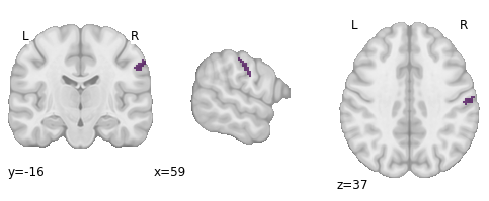

In [126]:
plotting.plot_roi(right_s1_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [127]:
# save the mask to path 
right_s1_aon_mask_path = f"{roi_dir}/right_s1_aon_mask.nii.gz"
right_s1_aon_mask.to_filename(right_s1_aon_mask_path)

**Left secondary somatosensory cortex (S2) * Conjunction**

In [128]:
# resample the mask
left_s2_resamp = image.resample_img(
    left_s2_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [129]:
left_s2_aon_mask = image.math_img("img1 * img2", 
                                   img1 = left_s2_resamp,
                                   img2 = conjunction_mask)

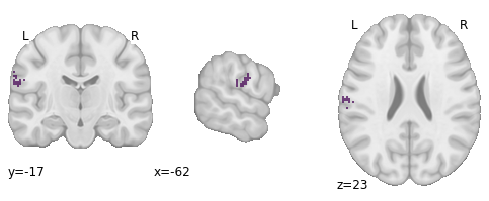

In [130]:
plotting.plot_roi(left_s2_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [131]:
# save the mask to path 
left_s2_aon_mask_path = f"{roi_dir}/left_s2_aon_mask.nii.gz"
left_s2_aon_mask.to_filename(left_s2_aon_mask_path)

**Right secondary somatosensory cortex (S2) * Conjunction**

In [132]:
# resample the mask
right_s2_resamp = image.resample_img(
    right_s2_mask,
    target_affine=conjunction_mask.affine,
    target_shape=conjunction_mask.shape[:3],
    interpolation='nearest'
)

In [133]:
right_s2_aon_mask = image.math_img("img1 * img2", 
                                   img1 = right_s2_resamp,
                                   img2 = conjunction_mask)

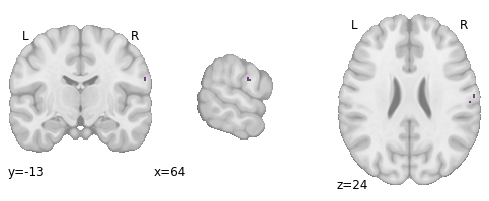

In [134]:
plotting.plot_roi(right_s2_aon_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

In [135]:
# save the mask to path 
right_s2_aon_mask_path = f"{roi_dir}/right_s2_aon_mask.nii.gz"
right_s2_aon_mask.to_filename(right_s2_aon_mask_path)

# Thats it - we end up with the following masks that I will use in the next script extract_signal.ipynb to extract the signal from each region:
- Left IPL AON mask
- Right IPL AON mask
- Left IFG AON mask
- Right IFG AON mask
- Left PM AON mask
- Right PM AON mask
- Left M1 AON mask
- Left S1 AON mask
- Right S1 AON mask
- Left S2 AON mask
- Right S2 AON mask
 
No overlap was found in the right primary motor cortex.